In [2]:
import dask.dataframe as dd
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import cross_val_score, KFold
from xgboost import XGBRegressor
import matplotlib.pyplot as plt
#from data_preprocessing_pao import *

# File download

In [3]:
X_file = "data/X_matrix.csv"
Y_file = "data/y_phenotype.csv"

print("Loading the data...")
X = pd.read_csv(X_file)
Y = pd.read_csv(Y_file)

Loading the data...


In [4]:
# Ensure Yeast_ID is a string type
X['Yeast_ID'] = X['Yeast_ID'].astype(str)
Y['Yeast_ID'] = Y['Yeast_ID'].astype(str)

# Filter to keep only the common Yeast_IDs
print("All Yeast_ID of X are in y: ", X['Yeast_ID'].isin(Y['Yeast_ID']).all())
print("All Yeast_ID of y are in X: ", Y['Yeast_ID'].isin(X['Yeast_ID']).all())

# Check if Yeast_ID columns are in the same order
if all(X["Yeast_ID"] == Y["Yeast_ID"]):
    print("Yeast_IDs are aligned and in the same order.")
else:
    print("Error: Yeast_IDs are not aligned after filtering.")

print("X contains NaN values: ", X.isna().any().any())
print("y contains NaN values: ", Y.isna().any().any())

# Display the dimensions of the filtered matrices
print(f"Dimensions de X : {X.shape}")
print(f"Dimensions de Y : {Y.shape}")

All Yeast_ID of X are in y:  True
All Yeast_ID of y are in X:  True
Yeast_IDs are aligned and in the same order.
X contains NaN values:  False
y contains NaN values:  False
Dimensions de X : (792, 347953)
Dimensions de Y : (792, 2)


In [6]:
# Préparation des données
print("Préparation des données...")
X_data = X.drop(columns=["Yeast_ID"])  # Remplacer les valeurs manquantes par 0 dans X
y_data = Y.drop(columns=["Yeast_ID"])
print(f"Dimensions de X : {X_data.shape}")
print(f"Dimensions de Y : {y_data.shape}")

Préparation des données...
Dimensions de X : (792, 347952)
Dimensions de Y : (792, 1)


In [64]:
# %%
import pandas as pd
import numpy as np
import re
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.decomposition import PCA
from sklearn.feature_extraction.text import TfidfVectorizer
from scipy.sparse import csr_matrix
from sklearn.feature_selection import VarianceThreshold
from sklearn.decomposition import TruncatedSVD
import dask.dataframe as dd
from sklearn.preprocessing import MinMaxScaler

def scale_last_columns(data, num_mutations=341901):
    """
    Scales the last N columns (assumed to be CNVs) to a range of 0 to 1.
    
    Parameters:
        data (pd.DataFrame): x_train data
        num_last_columns (int): Number of copy number variation columns from the end to scale .

    Returns:
        pd.DataFrame: Data with the last columns scaled.
    """
    # Select the last N columns
    cnv_columns = data.iloc[:, num_mutations:]
    
    # Scale these columns
    scaler = MinMaxScaler()
    scaled_cnv = scaler.fit_transform(cnv_columns)
    
    # Replace the last N columns with their scaled values
    data.iloc[:, num_mutations:] = scaled_cnv
    
    return data


def remove_low_variance_features_last_columns(data, num_mutations=341901, threshold=0.05):
    """
    Removes features with variance below a specified threshold in the last N columns.
    This has been done already for mutations during our extraction of data, so it is only useful to do it for the copy number variation columns.
    
    Parameters:
        data (pd.DataFrame): Input data.
        num_mutations (int): Number of mutations to not apply variance filtering.
        threshold (float): Minimum variance a feature must have to be retained.

    Returns:
        pd.DataFrame: Data with low-variance features removed in the last N columns.
    """
    # Select the last N columns
    target_columns = data.iloc[:, num_mutations:]
    
    # Apply VarianceThreshold to these columns
    selector = VarianceThreshold(threshold=threshold)
    reduced_data = selector.fit_transform(target_columns)
    
    # Get the selected column indices
    selected_columns = target_columns.columns[selector.get_support()]
    
    # Ensure new DataFrame has the correct index
    reduced_data_df = pd.DataFrame(reduced_data, columns=selected_columns, index=target_columns.index)
    
    # Replace the last N columns with the reduced set
    data = pd.concat([data.iloc[:, :num_mutations], reduced_data_df], axis=1)
    
    return data


def apply_pca_last_columns(data, num_mutations=341901, n_components=0.95, normalize=True):
    """
    Applies PCA to reduce dimensionality of the last N columns of the dataset.
    
    Parameters:
        data (pd.DataFrame): Input data.
        num_last_columns (int): Number of columns from the end to apply PCA.
        n_components (float or int): Number of components to keep or the amount of variance to retain.

    Returns:
        pd.DataFrame: Data with PCA applied to the last N columns.
    """
    # Separate the last N columns and the rest of the dataset
    other_columns = data.iloc[:, :num_mutations]
    target_columns = data.iloc[:, num_mutations:]
    
    # Apply PCA to the last N columns
    pca = PCA(n_components=n_components)
    reduced_data = pca.fit_transform(target_columns)

    # Normalize the PCA-transformed features if specified
    if normalize:
        scaler = MinMaxScaler()
        reduced_data = scaler.fit_transform(reduced_data)
    
    # Create a new DataFrame for the reduced PCA data
    reduced_columns = [f'PCA_{i+1}' for i in range(reduced_data.shape[1])]
    reduced_df = pd.DataFrame(reduced_data, columns=reduced_columns, index=data.index)
    
    # Concatenate the other columns with the reduced PCA columns
    result = pd.concat([other_columns, reduced_df], axis=1)
    
    return result


def metrics(x_train, x_train_preprocessed):
    """
    Compute and display various metrics for the original and preprocessed data.
    
    Parameters:
        x_train (pd.DataFrame): Original data.
        x_train_preprocessed (pd.DataFrame): Preprocessed data.
    """
    # Compute and print dimensions
    print("Dimensions of the DataFrame (original):", x_train.shape)
    print("Dimensions of the DataFrame (after preprocessing):", x_train_preprocessed.shape)

    # Exclude the first row and column for calculations
    x_cut = x_train.iloc[1:, 1:]
    x_cut_p = x_train_preprocessed.iloc[1:, 1:]

    # Compute and print mean
    mean_value_x_train = x_cut.values.mean()
    mean_value_x_train_preprocessed = x_cut_p.values.mean()
    print("\nMean of all values (original):", mean_value_x_train)
    print("Mean of all values (after preprocessing):", mean_value_x_train_preprocessed)

    # Compute and print max and min
    max_value_x_train = np.max(x_cut.values)
    min_value_x_train = np.min(x_cut.values)
    max_value_x_train_preprocessed = np.max(x_cut_p.values)
    min_value_x_train_preprocessed = np.min(x_cut_p.values)
    print("\nMax value (original):", max_value_x_train, "Min value (original):", min_value_x_train)
    print("Max value (after preprocessing):", max_value_x_train_preprocessed, "Min value (after preprocessing):", min_value_x_train_preprocessed)

    # Compute and print standard deviation
    std_x_train = x_cut.values.std()
    std_x_train_preprocessed = x_cut_p.values.std()
    print("\nStandard deviation (original):", std_x_train)
    print("Standard deviation (after preprocessing):", std_x_train_preprocessed)

    # Compute and print variance
    var_x_train = x_cut.values.var()
    var_x_train_preprocessed = x_cut_p.values.var()
    print("\nVariance (original):", var_x_train)
    print("Variance (after preprocessing):", var_x_train_preprocessed)

def preprocessed_data (x_df, y_df) :
    x_train_scaled = scale_last_columns(x_df)
    x_train_lv = remove_low_variance_features_last_columns(x_train_scaled)
    x_train = apply_pca_last_columns(x_train_lv)

    return x_train, y_df

In [49]:
X_data_f, y_data_f = preprocessed_data(X_data, y_data)

In [50]:
metrics(X_data,X_data_f)

Dimensions of the DataFrame (original): (792, 347952)
Dimensions of the DataFrame (after preprocessing): (792, 341990)

Mean of all values (original): 0.031414799995161016
Mean of all values (after preprocessing): 0.025658214514454155

Max value (original): 1.0 Min value (original): 0.0
Max value (after preprocessing): 1.0 Min value (after preprocessing): 0.0

Standard deviation (original): 0.16387554719923494
Standard deviation (after preprocessing): 0.15803376183534157

Variance (original): 0.02685519496984868
Variance (after preprocessing): 0.02497466987982946


In [51]:
# Division des données en ensembles d'entraînement et de test
print("Division des données en ensemble d'entraînement et de test...")
X_train, X_test, y_train, y_test = train_test_split(X_data_f, y_data_f, test_size=0.2, random_state=42)

# Affichage des dimensions des ensembles pour validation
print(f"Dimensions de X_train: {X_train.shape}")
print(f"Dimensions de X_test: {X_test.shape}")
print(f"Dimensions de y_train: {y_train.shape}")
print(f"Dimensions de y_test: {y_test.shape}")

Division des données en ensemble d'entraînement et de test...
Dimensions de X_train: (633, 341990)
Dimensions de X_test: (159, 341990)
Dimensions de y_train: (633,)
Dimensions de y_test: (159,)


# Random Forest

In [52]:
# Entraîner un modèle Random Forest
print("Entraînement du modèle Random Forest...")
model = RandomForestRegressor(random_state=42, n_estimators=100)
model.fit(X_train, y_train)

Entraînement du modèle Random Forest...


RandomForestRegressor(random_state=42)

In [53]:
# Prédictions
print("Évaluation du modèle...")
y_pred = model.predict(X_test)

Évaluation du modèle...


# XGBoost

In [55]:
# Définir un modèle XGBoost
print("Définition du modèle XGBoost...")
xgb_model = XGBRegressor(
    n_estimators=100,  # Nombre d'arbres
    max_depth=6,       # Profondeur maximale des arbres
    learning_rate=0.1, # Taux d'apprentissage
    subsample=0.8,     # Sous-échantillonnage des données
    colsample_bytree=0.8,  # Sous-échantillonnage des features
    random_state=42
)

#Validation croisée sur xgb
print("Lancement de la validation croisée...")
kf = KFold(n_splits=5, shuffle=True, random_state=42)  # Validation croisée en 5-fold
cv_scores = cross_val_score(xgb_model, X_data_f, y_data_f, cv=kf, scoring="r2")

print(f"Scores de validation croisée (R²): {cv_scores}")

Définition du modèle XGBoost...
Lancement de la validation croisée...
Scores de validation croisée (R²): [-0.01860866 -0.00875458  0.05244922 -0.30572404 -0.14285072]


In [ ]:
# Entraîner le modèle sur l'ensemble des données d'entraînement
print("Entraînement du modèle sur l'ensemble des données...")
xgb_model.fit(X_data_f, y_data_f)

Entraînement du modèle sur l'ensemble des données...
Division des données pour évaluation...
Prédictions sur les données de test...


# Predictions

In [56]:
# Entraînement final sur les données d'entraînement
xgb_model.fit(X_train, y_train)

# Prédictions
print("Prédictions sur les données de test...")
y_pred = xgb_model.predict(X_test)

Prédictions sur les données de test...


In [57]:
# Calcul des métriques
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f"Mean Squared Error: {mse}")
print(f"R² Score: {r2}")

# Importance des caractéristiques
print("Calcul de l'importance des caractéristiques...")
feature_importances = pd.DataFrame({
    "Feature": X_data_f.columns,
    "Importance": model.feature_importances_
}).sort_values(by="Importance", ascending=False)

# Afficher les mutations les plus importantes
top_mutations = feature_importances.head(10)
print("\nMutations ayant le plus d'impact sur le YPD doubling time :")
print(top_mutations)

Mean Squared Error: 0.08791647673952753
R² Score: -0.05392471462396653
Calcul de l'importance des caractéristiques...

Mutations ayant le plus d'impact sur le YPD doubling time :
                  Feature  Importance
226553  YLR320W_1167_E->G    0.019304
198668   YKL218C_169_G->R    0.011532
199364   YKR003W_411_A->V    0.010144
313428   YOR346W_825_V->I    0.009639
41281    YDL039C_246_V->A    0.009031
1812      YAL028W_67_A->T    0.008638
32090     YCL052C_29_T->I    0.008602
45896    YDL127W_180_K->I    0.008396
138038  YHL030W_1282_L->W    0.007985
247803  YMR105W-A_60_I->F    0.006896


Affichage des résultats...


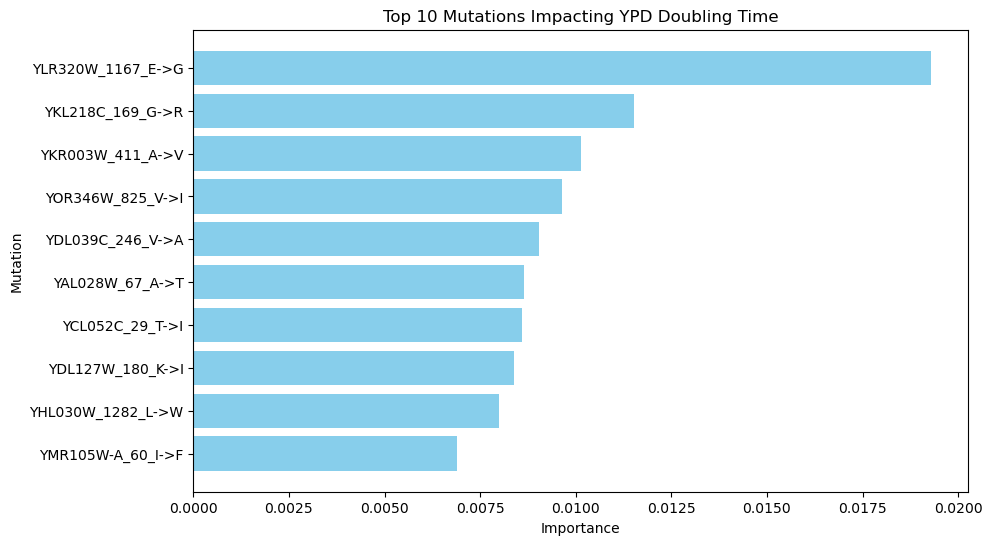

In [58]:
# Visualisation des résultats
print("Affichage des résultats...")
plt.figure(figsize=(10, 6))
plt.barh(top_mutations["Feature"], top_mutations["Importance"], color="skyblue")
plt.xlabel("Importance")
plt.ylabel("Mutation")
plt.title("Top 10 Mutations Impacting YPD Doubling Time")
plt.gca().invert_yaxis()
plt.show()

# Lasso

In [26]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import ShuffleSplit, GridSearchCV
from sklearn.linear_model import LassoCV
import json
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
from preprocessing import *

In [7]:
X_data_f, y_data_f = preprocessed_data(X_data, y_data)

In [8]:
# Division des données en ensembles d'entraînement et de test
print("Division des données en ensembles d'entraînement et de test...")
sss = ShuffleSplit(n_splits=1, test_size=0.25, random_state=42)
train_index, test_index = next(sss.split(X_data_f, y_data_f))

X_train, X_test = X_data_f.iloc[train_index, :], X_data_f.iloc[test_index, :]
y_train, y_test = y_data_f.iloc[train_index, :], y_data_f.iloc[test_index, :]

# Affichage des dimensions des ensembles divisés
print(f"Dimensions de X_train : {X_train.shape}")
print(f"X_test : {X_test.shape}")
print(f"Dimensions de y_train : {y_train.shape}")
print(f"y_test : {y_test.shape}")

Division des données en ensembles d'entraînement et de test...
Dimensions de X_train : (594, 341965)
X_test : (198, 341965)
Dimensions de y_train : (594, 1)
y_test : (198, 1)


In [27]:
# Hyperparameter tuning using LassoCV
lasso_cv = LassoCV(
    alphas=np.logspace(-4, 1, 50),  # Search over a range of alpha values
    cv=5,                           # 5-fold cross-validation
    random_state=42
)

In [28]:
# Fit LassoCV to the training data
lasso_cv.fit(X_train, y_train)

/opt/miniconda3/envs/ml/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:1656: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/miniconda3/envs/ml/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.782e-03, tolerance: 1.925e-03
  model = cd_fast.enet_coordinate_descent(
/opt/miniconda3/envs/ml/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.674e-03, tolerance: 1.925e-03
  model = cd_fast.enet_coor

LassoCV(alphas=array([1.00000000e-04, 1.26485522e-04, 1.59985872e-04, 2.02358965e-04,
       2.55954792e-04, 3.23745754e-04, 4.09491506e-04, 5.17947468e-04,
       6.55128557e-04, 8.28642773e-04, 1.04811313e-03, 1.32571137e-03,
       1.67683294e-03, 2.12095089e-03, 2.68269580e-03, 3.39322177e-03,
       4.29193426e-03, 5.42867544e-03, 6.86648845e-03, 8.68511374e-03,
       1.09854114e-02, 1.38949549e-0...
       7.19685673e-02, 9.10298178e-02, 1.15139540e-01, 1.45634848e-01,
       1.84206997e-01, 2.32995181e-01, 2.94705170e-01, 3.72759372e-01,
       4.71486636e-01, 5.96362332e-01, 7.54312006e-01, 9.54095476e-01,
       1.20679264e+00, 1.52641797e+00, 1.93069773e+00, 2.44205309e+00,
       3.08884360e+00, 3.90693994e+00, 4.94171336e+00, 6.25055193e+00,
       7.90604321e+00, 1.00000000e+01]),
        cv=5, random_state=42)

In [29]:
# Best alpha value
best_alpha = lasso_cv.alpha_
print(f"Optimal Alpha: {best_alpha}")

Optimal Alpha: 0.008685113737513529


In [30]:
# Evaluate model performance on validation set
y_pred = lasso_cv.predict(X_test)

In [31]:
# Sauvegarder les résultats
pd.DataFrame(y_pred, index=y_data_f.iloc[test_index, :].index, columns=y_data_f.columns).to_csv('results/y_test_predicted_LASSO.csv')
pd.DataFrame(y_test, index=y_data_f.iloc[test_index, :].index, columns=y_data_f.columns).to_csv('results/y_test_true_LASSO.csv')

In [32]:
# Calcul des métriques
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f"Mean Squared Error (MSE): {mse:.6f}")
print(f"R² Score: {r2:.6f}")

Mean Squared Error (MSE): 0.069916
R² Score: 0.052470


In [33]:
# Save feature importances
coefficients_df = pd.DataFrame(
    lasso_cv.coef_.reshape(1, -1),  # Ensure coefficients are a row vector
    columns=X_train.columns  # Feature names
)
coefficients_df.to_csv('results/LASSO_feature_importances.csv', index=False)

Affichage des résultats...


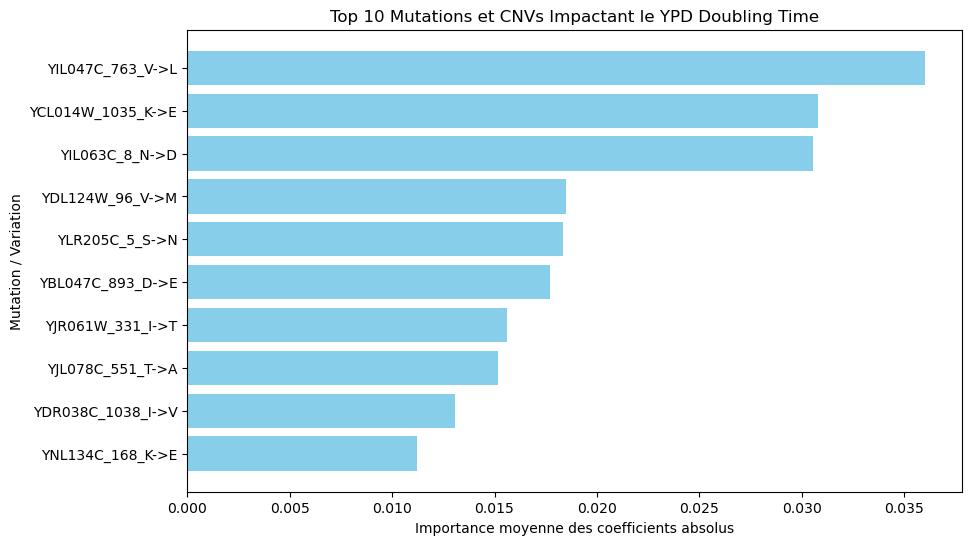

In [34]:
# Visualisation des résultats
print("Affichage des résultats...")
top_features = coefficients_df.abs().mean(axis=0).sort_values(ascending=False).head(10)
plt.figure(figsize=(10, 6))
plt.barh(top_features.index, top_features.values, color="skyblue")
plt.xlabel("Importance moyenne des coefficients absolus")
plt.ylabel("Mutation / Variation")
plt.title("Top 10 Mutations et CNVs Impactant le YPD Doubling Time")
plt.gca().invert_yaxis()
plt.show()

In [84]:
# Enregistrement des métadonnées
with open(f'results/LASSO_model_metadata.json', 'w+') as f:
    metadata = {
        'best_alpha': best_alpha,
        'mse': mse,
        'r2_score': r2,
        'training_samples': len(X_train),
        'testing_samples': len(X_test)
    }
    json.dump(metadata, f)
print("Les métadonnées du modèle ont été sauvegardées.")

Les métadonnées du modèle ont été sauvegardées.
